In [38]:
# import spark
from pyspark.sql import SparkSession

# Spark 세션 시작
spark = SparkSession.builder.appName("example").getOrCreate()


In [39]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

In [40]:
import pandas as pd

df = pd.read_csv('full_dataset.csv')

df = spark.createDataFrame(df)

display(df)


DataFrame[ID: bigint, Type: string, Cotton: double, Organic_cotton: double, Linen: double, Hemp: double, Jute: double, Other_plant: double, Silk: double, Wool: double, Leather: double, Camel: double, Cashmere: double, Alpaca: double, Feathers: double, Other_animal: double, Polyester: double, Nylon: double, Acrylic: double, Spandex: double, Elastane: double, Polyamide: double, Other_synthetic: double, Lyocell: double, Viscose: double, Acetate: double, Modal: double, Rayon: double, Other_regenerated: double, Other: double, Recycled_content: double, Reused_content: double, Material_label: bigint, Chemicals_label: bigint, Production_label: bigint, Manufacturing_location: string, Transporation_distance: double, Use_location: string, Washing_instruction: string, Drying_instruction: string, Reusability_label: bigint, Recylability_label: bigint, EI: bigint]

In [41]:
# 범주형 변수를 수치형으로 변환
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Manufacturing_location", "Use_location", "Washing_instruction", "Drying_instruction"]]
pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df).transform(df)

# 변환 후 기존의 칼럼 삭제
df_r = df_r.drop("Manufacturing_location", "Use_location", "Washing_instruction", "Drying_instruction")


In [42]:
# 피처와 타겟 변수 정의
featureCols = [col for col in df_r.columns if col not in ['ID', 'EI', 'Type'] + [column+"_index" for column in ["Manufacturing_location", "Use_location", "Washing_instruction", "Drying_instruction"]]]
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

In [43]:
# 데이터 분리
(trainData, testData) = df_r.randomSplit([0.8, 0.2], seed=42)

In [44]:
# define the model and train
rf = RandomForestRegressor(featuresCol="features", labelCol="EI")
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(trainData)

In [45]:
# model evaluation
predictions = model.transform(testData)
evaluator = RegressionEvaluator(labelCol="EI", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.443251


In [46]:
# hyperparameter tuning
rf = RandomForestRegressor(featuresCol="features", labelCol="EI", numTrees=100, maxDepth=20, minInstancesPerNode=5)
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(trainData)

24/03/05 21:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1064.9 KiB
24/03/05 21:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1146.7 KiB
24/03/05 21:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1223.5 KiB
24/03/05 21:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB
24/03/05 21:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1274.5 KiB
24/03/05 21:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1175.8 KiB
24/03/05 21:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1045.9 KiB


In [47]:
# model evaluation
predictions = model.transform(testData)
evaluator = RegressionEvaluator(labelCol="EI", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.311093


MSE: 0.09677909411456408
Kendall's Tau: 0.8245829936381747


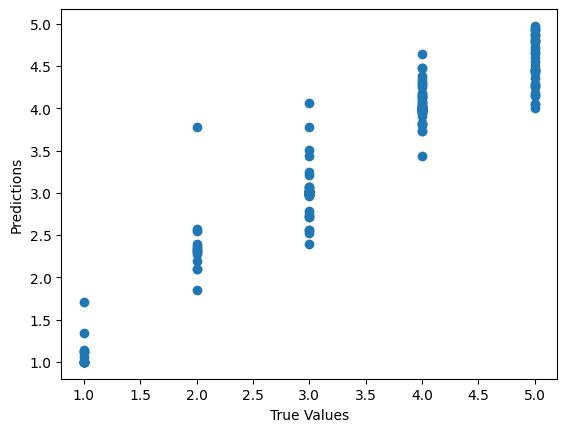

In [48]:
from pyspark.ml.evaluation import RegressionEvaluator
from scipy.stats import kendalltau
from sklearn.metrics import mean_squared_error

# 예측 생성
predictions = model.transform(testData)

# 예측 및 실제 레이블 추출
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
y_true = predictions.select("EI").rdd.flatMap(lambda x: x).collect()

# 메트릭 계산
mse = mean_squared_error(y_true, y_pred)
tau, _ = kendalltau(y_true, y_pred)

# 메트릭 출력
print(f"MSE: {mse}")
print(f"Kendall's Tau: {tau}")

# 시각화
import matplotlib.pyplot as plt
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [84]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Create a parameter grid for cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="EI", predictionCol="prediction", metricName="rmse")

# Define cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) # Perform 5-fold cross-validation

# Perform cross-validation
cvModel = crossval.fit(trainData)


24/03/05 22:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1019.9 KiB
24/03/05 22:29:44 WARN DAGScheduler: Broadcasting large task binary with size 1025.3 KiB
24/03/05 22:29:44 WARN DAGScheduler: Broadcasting large task binary with size 1014.3 KiB
24/03/05 22:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1056.6 KiB
24/03/05 22:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1122.7 KiB
24/03/05 22:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1146.5 KiB
24/03/05 22:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1142.6 KiB
24/03/05 22:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
24/03/05 22:30:03 WARN DAGScheduler: Broadcasting large task binary with size 1058.6 KiB
24/03/05 22:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB
24/03/05 22:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1179.3 KiB
24/03/05 22:30:04 WAR

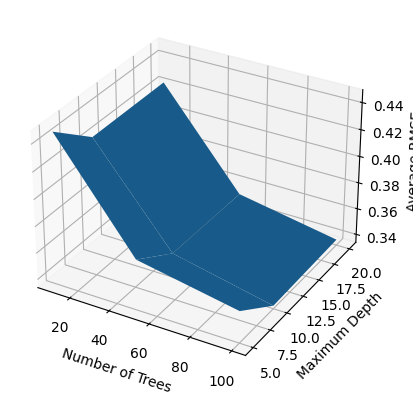

best numtrees:  50
best maxdepth:  20
Root Mean Squared Error (RMSE) on test data of best model = 0.301675


In [100]:
# plot the results
import matplotlib.pyplot as plt
import numpy as np

# Extract the number of trees and the maximum depth from the parameter grid and the average RMSE from the cross-validation model
num_trees = [10, 50, 100]
max_depth = [5, 10, 20]
avg_rmse = cvModel.avgMetrics

# Create a 2D grid
X, Y = np.meshgrid(num_trees, max_depth)
Z = np.array(avg_rmse).reshape(len(max_depth), len(num_trees))

# Plot the grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

# Add labels
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Maximum Depth')
ax.set_zlabel('Average RMSE')

# Show the plot
plt.show()

# Extract the best model
best_model = cvModel.bestModel

# describe the best model
print("best numtrees: ", best_model.stages[-1]._java_obj.getNumTrees())
print("best maxdepth: ", best_model.stages[-1]._java_obj.getMaxDepth())

# model evaluation
predictions = best_model.transform(testData)
evaluator = RegressionEvaluator(labelCol="EI", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data of best model = %g" % rmse)


In [111]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a parameter grid for cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="EI", predictionCol="prediction", metricName="accuracy")

# Define cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) # Perform 5-fold cross-validation

# Perform cross-validation
cvModel = crossval.fit(trainData)

# Extract the best model
best_model = cvModel.bestModel

# describe the best model
print("best numtrees: ", best_model.stages[-1]._java_obj.getNumTrees())
print("best maxdepth: ", best_model.stages[-1]._java_obj.getMaxDepth())

# model evaluation
predictions = best_model.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="EI", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy on test data of best model = %g" % accuracy)


24/03/05 23:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1019.9 KiB
24/03/05 23:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1025.3 KiB
24/03/05 23:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1014.3 KiB
24/03/05 23:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1056.6 KiB
24/03/05 23:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1122.7 KiB
24/03/05 23:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1146.5 KiB
24/03/05 23:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1142.6 KiB
24/03/05 23:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
24/03/05 23:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1058.6 KiB
24/03/05 23:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB
24/03/05 23:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1179.3 KiB
24/03/05 23:15:54 WAR

best numtrees:  10
best maxdepth:  20
Accuracy on test data of best model = 0


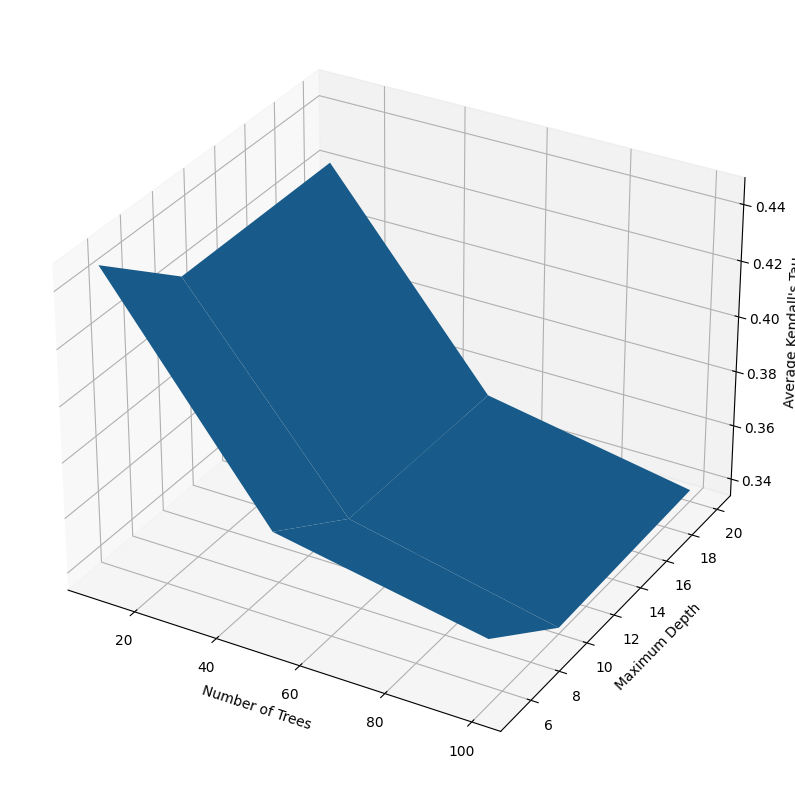

best numtrees:  50
best maxdepth:  20


IllegalArgumentException: RegressionEvaluator_99caffc84a37 parameter metricName given invalid value kendall.

In [107]:
# plot the results
import matplotlib.pyplot as plt
import numpy as np

# extract num trees and max depth and accuracy
num_trees = [10, 50, 100]
max_depth = [5, 10, 20]




In [76]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# 아이템의 소재 비율에 대한 데이터만 선택
material_columns = ['Cotton', 'Organic_cotton', 'Linen', 'Hemp', 'Jute', 'Other_plant', 'Silk', 'Wool']
materials_data = df[material_columns]

# Convert PySpark DataFrame to Pandas DataFrame
materials_data = materials_data.toPandas()

print(type(materials_data))

# standardize the data
scaler = StandardScaler()
materials_scaled = scaler.fit_transform(materials_data.values)

# cosine similarity 계산
cosine_sim = cosine_similarity(materials_scaled)

cosine_sim

# 특정 아이템(ID)에 대한 유사 아이템 추천 함수 정의
def recommend_items(item_id, cosine_sim=cosine_sim, items=df, top_n=5):
    # df 가 pandas DataFrame 이 아닌 경우 pandas DataFrame 으로 변환
    if not isinstance(items, pd.DataFrame):
        items = items.toPandas()
        
    # 아이템 인덱스 찾기
    item_idx = items[items['ID'] == item_id].index[0]
    
    # 모든 아이템에 대한 해당 아이템의 유사도 가져오기
    sim_scores = list(enumerate(cosine_sim[item_idx]))
    
    # 유사도에 따라 아이템들 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 가장 유사한 top_n 아이템의 인덱스
    sim_scores = sim_scores[1:top_n+1]  # 가장 유사한 아이템(자기 자신)을 제외
    
    # 아이템 인덱스 추출
    item_indices = [i[0] for i in sim_scores]
    
    # 가장 유사한 아이템들 반환
    return items.iloc[item_indices]

# 예시: ID가 1인 아이템과 가장 유사한 상위 5개 아이템 추천
recommended_items = recommend_items(1, cosine_sim, df, 5)
recommended_items[['ID', 'Type', 'EI']]



<class 'pandas.core.frame.DataFrame'>


,ID,Type,EI
1,2,jeans,1
2,3,jeans,1
3,4,jacket,1
4,5,jacket,1
20,21,jeans,1


In [80]:
# 유저가 선택한 아이템에 대한 유사한 아이템을 추천하되 EI 가 낮은 아이템을 우선 추천
def recommend_items_low_EI(item_id, cosine_sim=cosine_sim, items=df, top_n=5):
    # df 가 pandas DataFrame 이 아닌 경우 pandas DataFrame 으로 변환
    if not isinstance(items, pd.DataFrame):
        items = items.toPandas()
        
    # 아이템 인덱스 찾기
    item_idx = items[items['ID'] == item_id].index[0]
    
    # 모든 아이템에 대한 해당 아이템의 유사도 가져오기
    sim_scores = list(enumerate(cosine_sim[item_idx]))
    
    # 유사도에 따라 아이템들 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 가장 유사한 top_n 아이템의 인덱스
    sim_scores = sim_scores[1:top_n+1]  # 가장 유사한 아이템(자기 자신)을 제외
    
    # 아이템 인덱스 추출
    item_indices = [i[0] for i in sim_scores]
    
    # 가장 유사한 아이템들 반환
    recommended_items = items.iloc[item_indices]
    
    # EI 가 낮은 순으로 정렬
    recommended_items = recommended_items.sort_values('EI')
    
    return recommended_items


# 예시: ID가 1인 아이템과 가장 유사한 상위 10개 아이템 추천
recommended_items = recommend_items_low_EI(30, cosine_sim, df, 10)
recommended_items[['ID', 'Type', 'EI']]


,ID,Type,EI
1,2,jeans,1
2,3,jeans,1
3,4,jacket,1
4,5,jacket,1
20,21,jeans,1
23,24,jeans,1
24,25,jeans,1
25,26,jeans,1
26,27,jeans,1
28,29,jeans,1


In [83]:
def recommend_items_with_EI(item_id):
    recommended_items = recommend_items(item_id, cosine_sim, df, 10)
    recommended_items_low_EI = recommend_items_low_EI(item_id, cosine_sim, df, 10)

    print("Recommended items without considering EI:")
    print(recommended_items[['ID', 'Type', 'EI']])
    print("\nRecommended items considering EI:")
    print(recommended_items_low_EI[['ID', 'Type', 'EI']])

# Call the function with item_id
recommend_items_with_EI(230)


Recommended items without considering EI:
      ID     Type  EI
74    75    jeans   3
92    93  t-shirt   3
118  119   jacket   3
120  121    jeans   4
121  122  t-shirt   4
122  123  t-shirt   4
125  126  t-shirt   4
127  128  t-shirt   3
128  129  t-shirt   3
129  130    jeans   3

Recommended items considering EI:
      ID     Type  EI
74    75    jeans   3
92    93  t-shirt   3
118  119   jacket   3
127  128  t-shirt   3
128  129  t-shirt   3
129  130    jeans   3
120  121    jeans   4
121  122  t-shirt   4
122  123  t-shirt   4
125  126  t-shirt   4


In [71]:
materials_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cotton          1136 non-null   float64
 1   Organic_cotton  1136 non-null   float64
 2   Linen           1136 non-null   float64
 3   Hemp            1136 non-null   float64
 4   Jute            1136 non-null   float64
 5   Other_plant     1136 non-null   float64
 6   Silk            1136 non-null   float64
 7   Wool            1136 non-null   float64
dtypes: float64(8)
memory usage: 71.1 KB


In [74]:
# feature importances ( to label EI )
featureImportances = model.stages[-1].featureImportances

# convert feature importances to list
importances = featureImportances.toArray()

# map feature importances to feature names
featureList = assembler.getInputCols()
featureImportanceDict = dict(zip(featureList, importances))

# rank features by importance
sortedFeatures = sorted(featureImportanceDict.items(), key=lambda x: x[1], reverse=True)

# print feature importances
print("Feature Importances:")
for i, (feature, importance) in enumerate(sortedFeatures, start=1):
    print(f"{i}. {feature}: {importance}")

Feature Importances:
1. Material_label: 0.2773189894220241
2. Organic_cotton: 0.2590133773089045
3. Production_label: 0.10787369917788281
4. Transporation_distance: 0.058452498194477294
5. Recycled_content: 0.05234532543357963
6. Lyocell: 0.05107253640805276
7. Polyester: 0.028933388369690467
8. Cotton: 0.02835338151277777
9. Chemicals_label: 0.026163071848914327
10. Nylon: 0.023513986211266033
11. Reused_content: 0.022012767434539598
12. Reusability_label: 0.010646020077596265
13. Viscose: 0.010395336411190063
14. Recylability_label: 0.009243021884616707
15. Spandex: 0.005365801735315505
16. Rayon: 0.005110593555835801
17. Wool: 0.004724894010973383
18. Elastane: 0.0046150367734724695
19. Acrylic: 0.004234167320298523
20. Cashmere: 0.0032853934218621673
21. Silk: 0.002876735934192153
22. Polyamide: 0.0016841454827521156
23. Leather: 0.001474187028914965
24. Linen: 0.0005054913144375186
25. Modal: 0.00038710428855909593
26. Other: 0.00018510584184416184
27. Feathers: 0.0001065504344459